In [3]:
import torch
import torchmetrics

In [7]:
preds = torch.randn(10, 5).softmax(dim=-1)
target = torch.randint(5, (10,))
preds.shape, target.shape

(torch.Size([10, 5]), torch.Size([10]))

In [10]:
def compute_metrics(outputs, targets):
    metrics = {
        'acc':  torchmetrics.Accuracy(),
        'precision': torchmetrics.Precision(),
        'recall': torchmetrics.Recall()
    }
    return {
        name: met(outputs, targets).item()
        for name, met in metrics.items()
    }

In [11]:
compute_metrics(preds, target)

{'acc': 0.10000000149011612,
 'precision': 0.10000000149011612,
 'recall': 0.10000000149011612}

## Rich table to csv

In [38]:
from rich.table import Table
from pandas import DataFrame

In [27]:
table = Table()
table.add_column('FN', justify='center')
table.add_column('LN', justify='center')
table.add_row('Virk', 'saab')
table.add_row('Virk2', 'saab2')

In [36]:
dd = {col.header: col._cells for col in table.__dict__['columns']}

In [39]:
DataFrame.from_dict(dd)

,FN,LN
0,Virk,saab
1,Virk2,saab2


## Logs files rotation control

In [1]:
from pathlib import Path
from jais.utils import load_config, ROOT_DIR
CNF = load_config(ROOT_DIR/'configs/default.yaml')

In [2]:
import time
import os
from datetime import datetime

In [3]:
time.time()

1637825309.4088724

In [13]:
def manage_log_files():
    # Get log files paths
    log_filespaths = list(Path(CNF.paths.logs_dir).glob('*.log'))
    # Function to split the timestamp from filepath
    get_time_from_filename = lambda x: float(x.stem.split('@')[-1])
    # Sort timestamps
    timestamps = sorted(
        list(map(get_time_from_filename, log_filespaths)),
        reverse=True)
    # Keep only n recent files
    timestamps = timestamps[: CNF.log.keep_n_recent_logs]
    # Remove old files
    for fp in log_filespaths:
        if get_time_from_filename(fp) not in timestamps:
            os.remove(fp)

[1637824728.1856616, 1637823676.8927422, 1637823669.286787]

In [6]:
for fp in log_filespaths:
    print(fp)

In [7]:
for ts in timestamps:
    print(time.gmtime(float(ts)))

time.struct_time(tm_year=2021, tm_mon=11, tm_mday=25, tm_hour=7, tm_min=18, tm_sec=48, tm_wday=3, tm_yday=329, tm_isdst=0)
time.struct_time(tm_year=2021, tm_mon=11, tm_mday=25, tm_hour=7, tm_min=1, tm_sec=16, tm_wday=3, tm_yday=329, tm_isdst=0)
time.struct_time(tm_year=2021, tm_mon=11, tm_mday=25, tm_hour=7, tm_min=1, tm_sec=9, tm_wday=3, tm_yday=329, tm_isdst=0)


## LR Schedulers testing

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler as lrs
from jais.models.example import Net

In [219]:
max_lr = 1.0
net = Net()
optm_fn = torch.optim.SGD(net.parameters(), lr=max_lr)
scheduler1 = lrs.ConstantLR(optm_fn, factor=0.1, total_iters=2)
scheduler2 = lrs.ExponentialLR(optm_fn, gamma=0.9)
scheduler = lrs.SequentialLR(optm_fn, schedulers=[scheduler1, scheduler2], milestones=[2])
lr_list = []
for i in range(100):
    # optm_fn.step()
    scheduler.step()
    lr_list.append(scheduler.get_lr())
lr_list.append(scheduler.get_lr())
X = range(101)
plt.figure(figsize=(10,5))
plt.plot(X, lr_list);

NotImplementedError: 

In [222]:
scheduler.step()

/home/virk/devs/Projects/JAIS/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [245]:
from typing import Tuple
def minmaxscaler(x: list, axis=0, min=0, max=1):
        x_std = (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))
        x_scaled  = x_std * (max - min) + min
        return x_scaled

def jais_lr_scheduler_values(num_epochs: int,
                             num_iters_per_epochs: int,
                             warmup_pct: float = 0.20,
                             lr_range: Tuple[float, float] = (0.01, 1e-6),
                             verbose: bool = False) -> list:
    # Number of iterations / batches in one epoch
    max_lr, min_lr = lr_range
    num_iters = num_iters_per_epochs
    n_steps = num_epochs * num_iters  # Total steps 
    n_warmup_steps = int(n_steps * warmup_pct)  # Number of warmup steps
    n_rem_steps = n_steps - n_warmup_steps  # Number of StepLR steps
    # Warmup lr values list
    warmup_lr = minmaxscaler(
        np.sqrt(np.linspace(min_lr, max_lr, num=n_warmup_steps)),
        min=min_lr, max=max_lr
    )
    n_steplr_epochs = int(n_rem_steps / num_iters) # Number of epochs for StepLR 
    # Remaining steps after warmup and StepLR
    n_rem_steps = n_steps - (n_warmup_steps + (n_steplr_epochs * num_iters))
    # StepLR values per epoch
    if n_rem_steps != 0: # Keep `min_lr` away for further adjustment
        steplr_epochs_lr = np.linspace(max_lr, min_lr * 10, num=n_steplr_epochs)
    else:
        # Do adjustments till `min_lr`
        steplr_epochs_lr = np.linspace(max_lr, min_lr, num=n_steplr_epochs)
    steplr_lr = np.repeat(steplr_epochs_lr, num_iters)  # StepLR values per 
    if n_rem_steps != 0:
        rem_lr = list(np.linspace(min_lr*10, min_lr, num=n_rem_steps))
        total_lr = list(warmup_lr) + list(steplr_lr) + rem_lr
    else:
        total_lr = list(warmup_lr) + list(steplr_lr)
    assert len(total_lr) == n_steps, f"total_lr = {len(total_lr)} but n_steps = {n_steps}."
    if verbose:
        plt.figure(figsize=(10,5))
        plt.title("JAIS Custom Learning Rate Scheduler")
        plt.plot(range(len(total_lr)), total_lr)
    return total_lr

total_lr = jais_lr_scheduler_values(11, 121)

In [243]:
from typing import Tuple
class OptmWithLRSWrapper:
    def __init__(self,
                 optm_fn,
                 num_epochs: int,
                 num_iters_per_epochs: int,
                 warmup_pct: float = 0.20,
                 lr_range: Tuple[float, float] = (0.01, 1e-6)) -> None:
        """Learning Rate Scheduler Wrapper"""
        self.optm_fn = optm_fn
        self.step_num = 0
        self.lr_list = jais_lr_scheduler_values(
            num_epochs=num_epochs,
            num_iters_per_epochs=num_iters_per_epochs,
            warmup_pct=warmup_pct,
            lr_range=lr_range)

    def step(self) -> None:
        self.update_lr()
        self.optm_fn.step()
    
    def update_lr(self) -> None:
        self.current_lr = self.lr_list[self.step_num]
        for param_group in self.optm_fn.param_groups:
            param_group['lr'] = self.current_lr
        self.step_num += 1

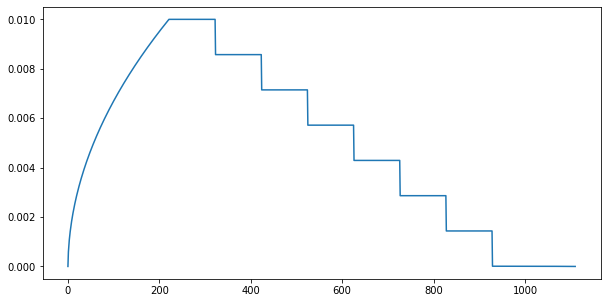

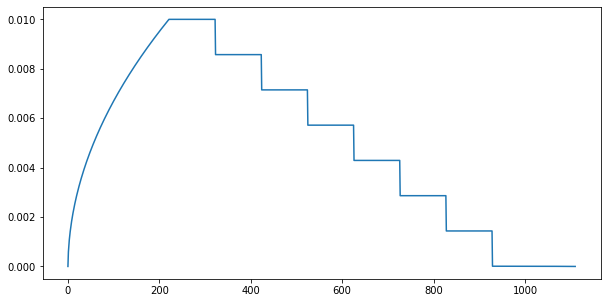

In [244]:

scheduler = OptmWithLRSWrapper(optm_fn, 11, 101)
lr_list = []
for i in range(11*101):
    # optm_fn.step()
    scheduler.step()
    lr_list.append(scheduler.current_lr)
X = range(len(lr_list))
plt.figure(figsize=(10,5))
plt.plot(X, lr_list);